In [99]:
import numpy as np

# translation matrix
trans = np.array(
    [[1., 0., 0., 0.],
     [0., 1., 0., 0.],
     [0., 0., 1., 0.],
     [0., 0.5, 0.5, 1.]]
)

# rotation matrix
rot = np.array(
    [[ 0.4198, -0.3450, -0.8395, 0.0000],
     [-0.2159,  0.8605, -0.4615, 0.0000],
     [ 0.8816,  0.3749,  0.2867, 0.0000],
     [ 0.0000,  0.0000,  0.0000, 1.0000]]
)

# rototranslation matrix
tr = (trans.T @ rot).T
rt = (rot @ trans.T).T
print(tr)
print(rt)

[[ 0.4198 -0.2159  0.8816  0.    ]
 [-0.345   0.8605  0.3749  0.    ]
 [-0.8395 -0.4615  0.2867  0.    ]
 [ 0.      0.5     0.5     1.    ]]
[[ 0.4198  -0.2159   0.8816   0.     ]
 [-0.345    0.8605   0.3749   0.     ]
 [-0.8395  -0.4615   0.2867   0.     ]
 [-0.59225  0.1995   0.3308   1.     ]]


In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torch
import torchvision


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

In [101]:
from models.neural_renderer import load_model

# Load trained chairs model
model = load_model('trained-models/chairs.pt').to(device)

/var/folders/n4/v_p7vlns5vd_ljr8d_pbswl00000gn/T/ipykernel_21531/454371865.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('imgs/example-data/chair4.png')


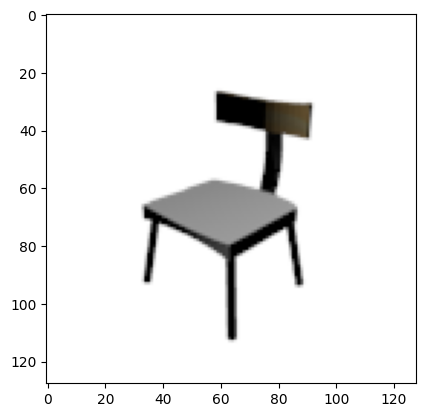

In [102]:
# You can also try loading other examples (e.g. 'chair1.png')
img = imageio.imread('imgs/example-data/chair4.png')
# Visualize image
plt.imshow(img)

In [103]:
from torchvision.transforms import ToTensor

# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# Print scene shape
print("Scene shape: {}".format(scene.shape))

Scene shape: torch.Size([1, 64, 32, 32, 32])


In [104]:
from transforms3d.rotations import rotate
import torch
from models.neural_renderer import load_model
import imageio
from torchvision.transforms import ToTensor


volume = scene

print(torch.tensor(trans, dtype=torch.float32).unsqueeze(0).shape)
print(volume.shape)

t = torch.tensor(trans, dtype=torch.float32).unsqueeze(0)
r = torch.tensor(rot, dtype=torch.float32).unsqueeze(0)
RT = torch.tensor(rt, dtype=torch.float32).unsqueeze(0)
TR = torch.tensor(tr, dtype=torch.float32).unsqueeze(0)

print(TR)
print(RT)

volume_t = model.rotate(volume, t)
volume_t_r = model.rotate(volume_t, r)
print("translate then rotate", volume_t_r[0, 0, 0, 0, 0])

volume_r = model.rotate(volume, r)
volume_r_t = model.rotate(volume_r, t)
print("rotate then translate", volume_r_t[0, 0, 0, 0, 0])

volume_tr = model.rotate(volume, TR)
print("tr", volume_tr[0, 0, 0, 0, 0])

volume_rt = model.rotate(volume, RT)
print("rt", volume_rt[0, 0, 0, 0, 0])

torch.Size([1, 4, 4])
torch.Size([1, 64, 32, 32, 32])
tensor([[[ 0.4198, -0.2159,  0.8816,  0.0000],
         [-0.3450,  0.8605,  0.3749,  0.0000],
         [-0.8395, -0.4615,  0.2867,  0.0000],
         [ 0.0000,  0.5000,  0.5000,  1.0000]]])
tensor([[[ 0.4198, -0.2159,  0.8816,  0.0000],
         [-0.3450,  0.8605,  0.3749,  0.0000],
         [-0.8395, -0.4615,  0.2867,  0.0000],
         [-0.5922,  0.1995,  0.3308,  1.0000]]])
translate then rotate tensor(0., grad_fn=<SelectBackward0>)
rotate then translate tensor(0., grad_fn=<SelectBackward0>)
tr tensor(0., grad_fn=<SelectBackward0>)
rt tensor(0., grad_fn=<SelectBackward0>)


In [105]:
print(torch.allclose(volume_rt, volume_tr))
print(torch.allclose(volume_t_r, volume_r_t))
print(torch.allclose(volume_t_r, volume_rt))
print(torch.allclose(volume_t_r, volume_tr))
print(torch.allclose(volume_r_t, volume_tr))
print(torch.allclose(volume_r_t, volume_rt))
print(torch.allclose(volume_t_r, torch.zeros_like(volume_t_r)))



False
False
False
False
False
False
False


In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision

def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

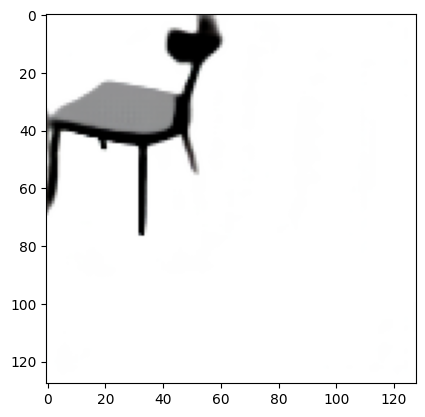

In [107]:
# Render rotated scene
rendered = model.render(volume_rt)
plot_img_tensor(rendered.detach())

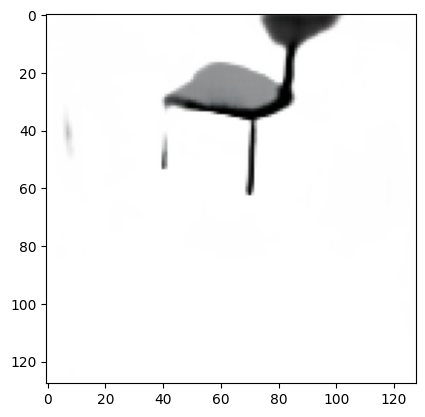

In [108]:
# Render rotated scene
rendered = model.render(volume_tr)
plot_img_tensor(rendered.detach())

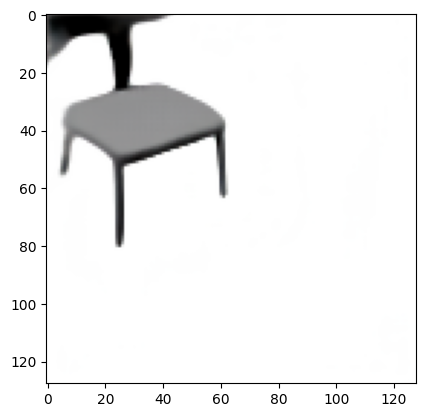

In [109]:
# Render rotated scene
rendered = model.render(volume_r_t)
plot_img_tensor(rendered.detach())

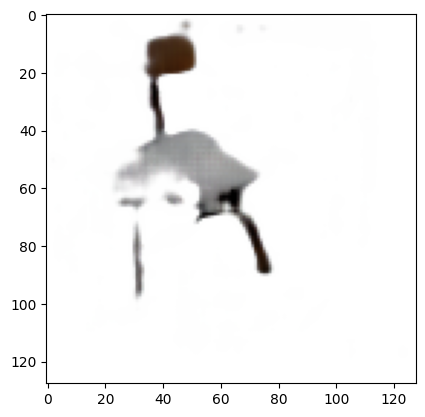

In [110]:
# Render rotated scene
rendered = model.render(volume_t_r)
plot_img_tensor(rendered.detach())